# Project Optimalisatietechnieken (22 mei 2020)
## Sam Vanmassenhove
### 2de Master Bioinformatics: Engineering

In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import itertools
import matplotlib.pyplot as plt
import numpy as np

## Lees dataset
Definieer functies om de data te lezen en om te zetten in objecten die later kunnen gebruikt worden.

In [2]:
# Function reads process data
def read_process(lines, process):
    index = lines.index("# " + process)
    p = lines[index+2].split("\t")
    c = lines[index+1][2:].split("\t")
    return {c[i]:p[i] if c[i] == "naam" else float(p[i]) for i in range(len(p))}

# Function reads ingredient data
def read_ingredient(lines, ingredient):
    index = lines.index("# " + ingredient)
    col_names = lines[index+1][2:].split("\t")
    data = list(itertools.takewhile(lambda x: "#" not in x, lines[index+2:]))
    temp_string = StringIO("\n".join(data))
    df = pd.read_csv(temp_string, header=None, names=col_names, sep="\t")
    return df

In [3]:
# Read the data file and process the format
f = open("dataset.txt", "r")
lines = [line.strip() for line in f.readlines() if line.strip()]

# Load process data
mout_process = read_process(lines, "moutproces")
maisch_process = read_process(lines, "maischproces")

# Load ingredient data
mout_data = read_ingredient(lines, "mouten")
gerst_data = read_ingredient(lines, "gersten")
hop_data = read_ingredient(lines, "hoppen")
gist_data = read_ingredient(lines, "gisten")
extract_data = read_ingredient(lines, "moutextracten")

### 3.1 Eerste analyse

In [4]:
def extract_to_volume(m_extract):
    """
    Convert a certain mass of extract into the correct volume of wort (in liters)
    """
    return m_extract / (2.9 * (1.050 - 1))

def get_cheapest_ingredient(ingredients):
    """
    Get the cheapest of a list of ingredients.
    """
    index = np.argmin((ingredients["kost"].to_numpy()))
    return ingredients.iloc[index]

def calc_process_cost(process, x_ingr, efficiency):
    """
    Calculate total cost of a process (variable cost + fixed cost), where x_ingr is the mass 
    of the ingredient used in the process.
    """
    var_cost = (process["variabelekost"]) * x_ingr * efficiency
    fixed_cost = (process["vastekost"])
    return fixed_cost + var_cost

def mout_to_extract(mout_mass):
    """
    Convert the mass of mout into the equivalent mass in extract.
    """
    return 0.8 * mout_mass

def gerst_to_mout(gerst_mass):
    """
    Convert the mass of gerst into the equivalent mass in mout after the mout-process.
    """
    return 0.75 * gerst_mass

In [5]:
# Get the cheapest 
gerst_cost = get_cheapest_ingredient(gerst_data)["kost"]
gist_cost = get_cheapest_ingredient(gist_data)["kost"]
hop_cost = get_cheapest_ingredient(hop_data)["kost"]

In [6]:
# Only use gerst
def gerst_only(x_g):
    mout_cost = calc_process_cost(mout_process, x_g, 0.75)
    x_m = gerst_to_mout(x_g)
    maisch_cost = calc_process_cost(maisch_process, x_m, 0.8)

    x_ex = mout_to_extract(x_m)
    vol = extract_to_volume(x_ex)
    x_hop = 0.0013*vol
    x_gist = 0.075/100 * (vol*0.95)
    total_cost = x_g*gerst_cost + mout_cost + maisch_cost + x_hop*hop_cost + x_gist*gist_cost
    return total_cost, vol*0.95

In [7]:
# Only use mout
def mout_only(x_m):
    m_cost = get_cheapest_ingredient(mout_data)["kost"]
    x_ex = mout_to_extract(x_m)
    maisch_cost = calc_process_cost(maisch_process, x_m, 0.8)

    vol = extract_to_volume(x_ex)
    x_hop = 0.0013*vol
    x_gist = 0.075/100 * (vol*0.95)
    total_cost = x_m*m_cost + maisch_cost + x_hop*hop_cost + x_gist*gist_cost
    return total_cost, vol*0.95

In [8]:
# Only use moutextract
def extract_only(x_me):
    me_cost = get_cheapest_ingredient(extract_data)["kost"]
    vol = extract_to_volume(x_me)

    x_hop = 0.0013*vol
    x_gist = 0.075/100 * (vol*0.95)

    total_cost = x_me*me_cost + x_hop*hop_cost + x_gist*gist_cost
    return total_cost, vol*0.95

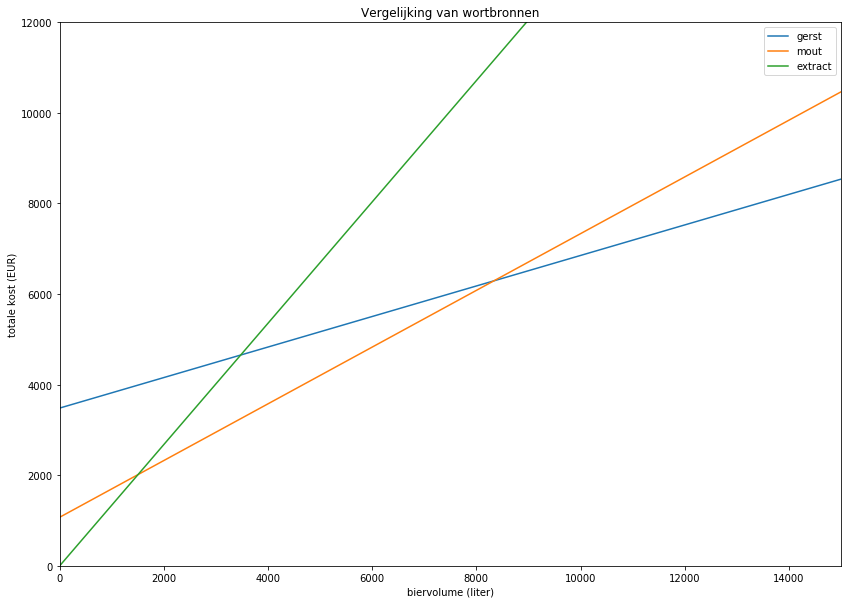

In [9]:
# Plot the total cost
x = np.linspace(0, 10_000)
y_g = [gerst_only(i)[0] for i in x]
x_g = [gerst_only(i)[1] for i in x]

y_m = [mout_only(i)[0] for i in x]
x_m = [mout_only(i)[1] for i in x]

y_e = [extract_only(i)[0] for i in x]
x_e = [extract_only(i)[1] for i in x]

p = plt.figure(figsize=(14, 10))
plt.plot(x_g, y_g)
plt.plot(x_m, y_m)
plt.plot(x_e, y_e)
plt.xlim(0, 15_000)
plt.ylim(0, 12_000)
plt.legend(["gerst", "mout", "extract"])
plt.xlabel("biervolume (liter)")
plt.ylabel("totale kost (EUR)")
plt.title("Vergelijking van wortbronnen")
plt.show()

## 3.2 Formulering als lineair programma

Zie het verslag voor uitleg over het lineir programma...

In [10]:
from Ingredient import Ingredient
from Process import Process
from IngredientHelper import IngredientHelper
from LPSolver import LPSolver

In [11]:
ih = IngredientHelper(gerst_data, 
                     mout_data,
                     extract_data,
                     hop_data,
                     gist_data,
                     mout_process,
                     maisch_process
                     )

In [12]:
# Display results in readable way
def display_results(res, thr=10**(-4)):
    # Remove small numbers to zero for clearer overview
    x = res.x
    x[x < thr] = 0
    mat = np.transpose(x[0:60].reshape(5, 12))
    df = pd.DataFrame(mat, columns=["gerst", "mout", "extract", "hop", "gist"])
    df.index += 1
    return df

## 3.3 Productie van 5000 liter amber bier
### Gegevens: 
- volume = 5000 liter
- EBC_min = 20
- EBC_max = 29

### Relaxeer het ILP en los op
Rond daarna de binaire variabelen af en bekijk het resultaat na afronding.

In [13]:
# Relaxation
solver = LPSolver(ih, y=None, method="revised simplex")
res, fun = solver._solve(5000, ebc_min=20, ebc_max=29, M=1000)
print(f"Optimal relaxed cost: {fun:.2f}")
print(f"(y1={res.x[-2]:.3f}, y2={res.x[-1]:.3f})")
display_results(res)

Optimal relaxed cost: 4237.08
(y1=0.000, y2=0.954)


,gerst,mout,extract,hop,gist
1,0.0,0.000000,0.0,0.000000,0.00
2,0.0,0.000000,0.0,0.000000,0.00
3,0.0,0.000000,0.0,0.000000,0.00
4,0.0,497.711670,0.0,0.000000,0.00
5,0.0,0.000000,0.0,0.000000,3.75
6,0.0,456.235698,0.0,0.000000,0.00
7,0.0,0.000000,0.0,6.842105,0.00
8,0.0,0.000000,0.0,0.000000,0.00
9,0.0,0.000000,0.0,0.000000,0.00
10,0.0,0.000000,0.0,0.000000,0.00


In [14]:
# Round to binary variables and calculate new cost
res.x[-2:] = np.round(res.x[-2:])
v = solver.ih.total_cost_vector()
s = sum(v[0] * res.x) + v[1]
print(f"Optimal relaxed rounded cost: {s}")

Optimal relaxed rounded cost: 4286.446510297485


In [15]:
# Solve with summation
solver = LPSolver(ih, y=None, method="revised simplex")
rlist, tlist, i = solver.solve(5000, 
                               ebc_min=20,
                               ebc_max=29, 
                               M=10**3, 
                               summation=True)
# Display summation results
l = [(0, 0), (0, 1), (1, 0), (1, 1)]
for index, t in enumerate(tlist):
    print("Optimal for", l[index], ":", tlist[index])
print("Global optimal solution", l[i],":" ,tlist[i])

f_5000 = tlist[i]
display_results(rlist[i])

Optimal for (0, 0) : 6769.57236842106
Optimal for (0, 1) : 4286.446510297485
Optimal for (1, 0) : 9179.57236842106
Optimal for (1, 1) : 5475.335526315792
Global optimal solution (0, 1) : 4286.446510297485


,gerst,mout,extract,hop,gist
1,0.0,0.000000,0.0,0.000000,0.00
2,0.0,0.000000,0.0,0.000000,0.00
3,0.0,0.000000,0.0,0.000000,0.00
4,0.0,497.711670,0.0,0.000000,0.00
5,0.0,0.000000,0.0,0.000000,3.75
6,0.0,456.235698,0.0,0.000000,0.00
7,0.0,0.000000,0.0,6.842105,0.00
8,0.0,0.000000,0.0,0.000000,0.00
9,0.0,0.000000,0.0,0.000000,0.00
10,0.0,0.000000,0.0,0.000000,0.00


## 3.4 Zelfde probleem maar met 50 en 25000 liter

### Eerst 50 liter, met zelfde voorwaarden als voordien

In [16]:
# Relaxation
solver = LPSolver(ih, y=None, method="revised simplex")
res, f = solver.solve(50, ebc_min=20, ebc_max=29, M=10)
print(res.x[-2:], res.fun)
display_results(res)

[0. 0.] 67.69572368421059


,gerst,mout,extract,hop,gist
1,0.0,0.0,0.000000,0.000000,0.0000
2,0.0,0.0,0.000000,0.000000,0.0000
3,0.0,0.0,0.000000,0.000000,0.0000
4,0.0,0.0,1.315789,0.000000,0.0000
5,0.0,0.0,0.000000,0.000000,0.0375
6,0.0,0.0,0.000000,0.000000,0.0000
7,0.0,0.0,0.000000,0.068421,0.0000
8,0.0,0.0,0.000000,0.000000,0.0000
9,0.0,0.0,0.000000,0.000000,0.0000
10,0.0,0.0,6.315789,0.000000,0.0000


In [17]:
# Round to binary variables and calculate new cost
res.x[-2:] = np.round(res.x[-2:])
v = solver.ih.total_cost_vector()
s = sum(v[0] * res.x) + v[1]
print(f"Optimal relaxed rounded cost: {s}")

Optimal relaxed rounded cost: 67.69572368421058


In [18]:
# Solve with summation
solver = LPSolver(ih, y=None, method="revised simplex")
rlist, tlist, i = solver.solve(50, 
                               ebc_min=20,
                               ebc_max=29, 
                               M=10**6, 
                               summation=True)
# Display summation results
l = [(0, 0), (0, 1), (1, 0), (1, 1)]
for index, t in enumerate(tlist):
    print("Optimal for", l[index], ":", tlist[index])
print("Global optimal solution", l[i],":" ,tlist[i])

f_50 = tlist[i]
display_results(rlist[i])

Optimal for (0, 0) : 67.69572368421059
Optimal for (0, 1) : 1104.144465102975
Optimal for (1, 0) : 2477.6957236842104
Optimal for (1, 1) : 3498.8428728070176
Global optimal solution (0, 0) : 67.69572368421059


,gerst,mout,extract,hop,gist
1,0.0,0.0,0.000000,0.000000,0.0000
2,0.0,0.0,0.000000,0.000000,0.0000
3,0.0,0.0,0.000000,0.000000,0.0000
4,0.0,0.0,1.315789,0.000000,0.0000
5,0.0,0.0,0.000000,0.000000,0.0375
6,0.0,0.0,0.000000,0.000000,0.0000
7,0.0,0.0,0.000000,0.068421,0.0000
8,0.0,0.0,0.000000,0.000000,0.0000
9,0.0,0.0,0.000000,0.000000,0.0000
10,0.0,0.0,6.315789,0.000000,0.0000


### Analoog voor 25000 liter

In [19]:
solver = LPSolver(ih, y=None)
res, f = solver.solve(25000, ebc_min=20, ebc_max=29, M=5000)
print(res.x[-2:], f)
display_results(res)

[1.         0.95394737] 13399.309290747728


,gerst,mout,extract,hop,gist
1,0.000000,0.00000,0.0,0.000000,0.000000
2,0.000000,0.00000,0.0,0.000000,0.000000
3,0.000000,0.00000,0.0,0.000000,0.000000
4,769.368705,0.00000,0.0,0.000000,0.000000
5,0.000000,0.00000,0.0,0.000000,18.749998
6,0.000000,1019.73679,0.0,0.000000,0.000000
7,0.000000,0.00000,0.0,34.210515,0.000000
8,0.000000,0.00000,0.0,0.000000,0.000000
9,4230.630337,0.00000,0.0,0.000000,0.000000
10,0.000453,0.00000,0.0,0.000000,0.000000


In [20]:
# Round to binary variables and calculate new cost
res.x[-2:] = np.round(res.x[-2:])
v = solver.ih.total_cost_vector()
s = sum(v[0] * res.x) + v[1]
print(f"Optimal relaxed rounded cost: {s}")

Optimal relaxed rounded cost: 13448.676496877159


In [21]:
# Solve with summation
solver = LPSolver(ih, y=None, method="revised simplex")
rlist, tlist, i = solver.solve(25_000, 
                               ebc_min=20,
                               ebc_max=29, 
                               M=10**6, 
                               summation=True)
# Display summation results
l = [(0, 0), (0, 1), (1, 0), (1, 1)]
for index, t in enumerate(tlist):
    print("Optimal for", l[index], ":", tlist[index])
print("Global optimal solution", l[i],":" ,tlist[i])

f_25000 = tlist[i]
display_results(rlist[i])

Optimal for (0, 0) : 33847.86184210529
Optimal for (0, 1) : 17144.23255148742
Optimal for (1, 0) : 36257.86184210529
Optimal for (1, 1) : 11903.436403508776
Global optimal solution (1, 1) : 11903.436403508776


,gerst,mout,extract,hop,gist
1,0.000000,0.0,0.0,0.000000,0.00
2,0.000000,0.0,0.0,0.000000,0.00
3,0.000000,0.0,0.0,0.000000,0.00
4,6359.649123,0.0,0.0,0.000000,0.00
5,0.000000,0.0,0.0,0.000000,18.75
6,0.000000,0.0,0.0,0.000000,0.00
7,0.000000,0.0,0.0,34.210526,0.00
8,0.000000,0.0,0.0,0.000000,0.00
9,0.000000,0.0,0.0,0.000000,0.00
10,0.000000,0.0,0.0,0.000000,0.00


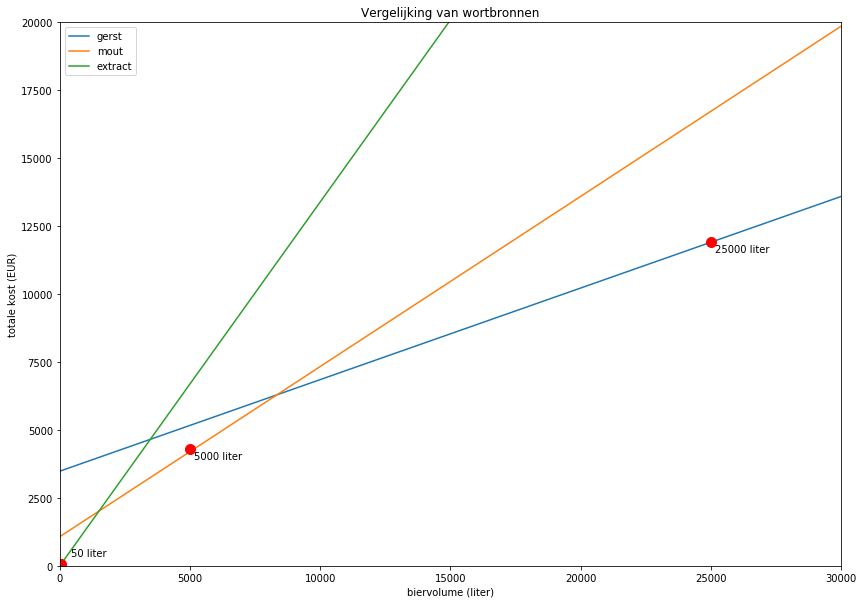

In [22]:
# Place onto the plot from Q3.1
p = plt.figure(figsize=(14, 10))
plt.plot(x_g, y_g)
plt.plot(x_m, y_m)
plt.plot(x_e, y_e)
plt.xlim(0, 30_000)
plt.ylim(0, 20_000)
plt.legend(["gerst", "mout", "extract"])
plt.xlabel("biervolume (liter)")
plt.ylabel("totale kost (EUR)")
plt.title("Vergelijking van wortbronnen")

plt.plot([50], [f_50], marker="o", color="red", markersize=10)
plt.plot([5000], [f_5000], marker="o", color="red", markersize=10)
plt.plot([25000], [f_25000], marker="o", color="red", markersize=10)
plt.annotate("50 liter", xy=(50, f_50), xytext=(10, 8), textcoords="offset points")
plt.annotate("5000 liter", xy=(5000, f_5000), xytext=(4, -10), textcoords="offset points")
plt.annotate("25000 liter", xy=(25000, f_25000), xytext=(4, -10), textcoords="offset points")
plt.show()

## 3.5 Volledig probleem
### Gegevens: 
- volume = 5000 liter
- EBC_min = 20
- EBC_max = 29
- Q_mout = 3
- Q_hop = 3
- Q_gist = 3

In [23]:
# Relaxation
solver = LPSolver(ih, y=None, method="revised simplex")
res, f = solver.solve(5000, 
                            ebc_min=20, 
                            ebc_max=29, 
                            q_mout=3,
                            q_hop=3,
                            q_gist=3,
                            M=10**3)
print(res.x[-2:], res.fun)
print(res.message)
display_results(res)

[3.51291110e-17 9.53947368e-01] 4678.0218228498115
Optimization terminated successfully.


,gerst,mout,extract,hop,gist
1,0.0,0.000000,0.0,0.000000,0.00
2,0.0,0.000000,0.0,0.000000,0.00
3,0.0,814.345315,0.0,0.000000,3.75
4,0.0,0.000000,0.0,0.000000,0.00
5,0.0,0.000000,0.0,0.000000,0.00
6,0.0,46.534018,0.0,0.000000,0.00
7,0.0,0.000000,0.0,3.421053,0.00
8,0.0,0.000000,0.0,0.000000,0.00
9,0.0,0.000000,0.0,0.000000,0.00
10,0.0,0.000000,0.0,3.421053,0.00


In [24]:
# Round to binary variables and calculate new cost
res.x[-2:] = np.round(res.x[-2:])
v = solver.ih.total_cost_vector()
s = sum(v[0] * res.x) + v[1]
print(f"Optimal relaxed rounded cost: {s}")

Optimal relaxed rounded cost: 4727.390243902442


In [25]:
# Solve with summation
solver = LPSolver(ih, y=None, method="revised simplex")
rlist, tlist, i = solver.solve(5_000, 
                               ebc_min=20,
                               ebc_max=29, 
                               q_mout=3,
                               q_hop=3,
                               q_gist=3,
                               M=10**6, 
                               summation=True)
# Display summation results
l = [(0, 0), (0, 1), (1, 0), (1, 1)]
for index, t in enumerate(tlist):
    print("Optimal for", l[index], ":", tlist[index])
print("Global optimal solution", l[i],":" ,tlist[i])

f_25000 = tlist[i]
display_results(rlist[i])

Optimal for (0, 0) : 7448.0637651821935
Optimal for (0, 1) : 4727.390243902442
Optimal for (1, 0) : 9858.063765182193
Optimal for (1, 1) : 5284.298589611284
Global optimal solution (0, 1) : 4727.390243902442


,gerst,mout,extract,hop,gist
1,0.0,0.000000,0.0,0.000000,0.00
2,0.0,0.000000,0.0,0.000000,0.00
3,0.0,814.345315,0.0,0.000000,3.75
4,0.0,0.000000,0.0,0.000000,0.00
5,0.0,0.000000,0.0,0.000000,0.00
6,0.0,46.534018,0.0,0.000000,0.00
7,0.0,0.000000,0.0,3.421053,0.00
8,0.0,0.000000,0.0,0.000000,0.00
9,0.0,0.000000,0.0,0.000000,0.00
10,0.0,0.000000,0.0,3.421053,0.00


## 3.6 Van lichtblond tot zwart
Doe nu hetzelfde maar voor alle bierkleuren. We gebruiken hier de methode met opsomming want we wensen enkel de echte optimale kosten voor het ILP, niet de approximaties van de relaxatie.

In [26]:
# Create Dict with all EBC values
colors = {"bleek/lichtblond":(6, 8), 
           "blond/geel": (9, 12),
           "goud": (13, 19),
           "amber": (20, 29),
           "koper": (30, 45),
           "donker koper/bruin": (46, 75),
           "zeer donker bruin": (76, 120),
           "zwart": (120, None)}

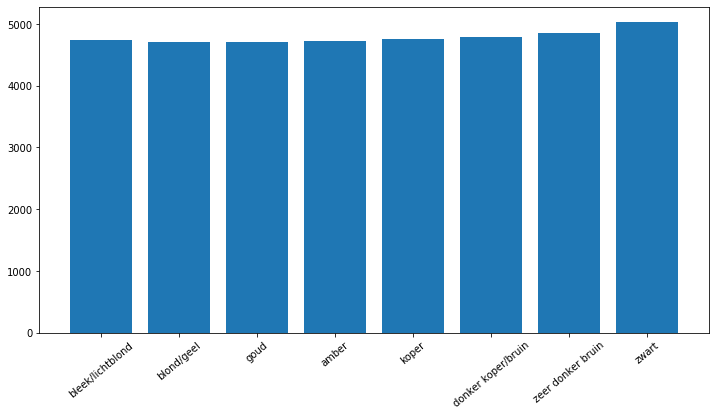

In [27]:
# Solve for each color
r = []
for k, v in colors.items():
    
    solver = LPSolver(ih, method="revised simplex")
    rlist, tlist, best_index = solver.solve(5000, 
                                          summation=True,
                                          ebc_min=v[0], 
                                          ebc_max=v[1], 
                                          q_mout=3,
                                          q_hop=3,
                                          q_gist=3,
                                          M=10**6)
    r.append([k, tlist[best_index]])

plt.figure(figsize=(12, 6))
plt.bar([i[0] for i in r], [i[1] for i in r])
plt.xticks(rotation=40)
plt.show()